In [3]:
import pandas as pd
import numpy as np

# Project introduction

For our machine learning project, we want to try and predict a Airbnb's avaliability for a given month using listing data.

# Data Preperation

In [2]:
# generate two data frames containing all of the listing and calendar data for each location
import os
import pandas as pd

directory_path = 'home_rentals/'

# Initialize an empty list to store DataFrames
listing_df = []
calendar_df = []

# Iterate through subdirectories
for subdirectory in os.listdir(directory_path):
    subdirectory_path = os.path.join(directory_path, subdirectory) 

    csv_listing_file_path = os.path.join(subdirectory_path, "listings.csv.gz")
    csv_calendar_file_path = os.path.join(subdirectory_path, "calendar.csv.gz")
    print(csv_listing_file_path)
    print(csv_calendar_file_path)

    df1 = pd.read_csv(csv_listing_file_path)
    df2 = pd.read_csv(csv_calendar_file_path)

    df1['location'] = subdirectory
    df2['location'] = subdirectory

    listing_df.append(df1)
    calendar_df.append(df2)


# Concatenate all DataFrames into a single DataFrame
all_listing_df = pd.concat(listing_df, ignore_index=True)
all_calendar_df = pd.concat(calendar_df, ignore_index=True)

home_rentals/Amsterdam\listings.csv.gz
home_rentals/Amsterdam\calendar.csv.gz
home_rentals/Barcelona\listings.csv.gz
home_rentals/Barcelona\calendar.csv.gz
home_rentals/Euskadi\listings.csv.gz
home_rentals/Euskadi\calendar.csv.gz
home_rentals/Geneva\listings.csv.gz
home_rentals/Geneva\calendar.csv.gz
home_rentals/Ireland\listings.csv.gz
home_rentals/Ireland\calendar.csv.gz
home_rentals/Lisbon\listings.csv.gz
home_rentals/Lisbon\calendar.csv.gz
home_rentals/Los Angeles\listings.csv.gz
home_rentals/Los Angeles\calendar.csv.gz
home_rentals/Madrid\listings.csv.gz
home_rentals/Madrid\calendar.csv.gz
home_rentals/Malaga\listings.csv.gz
home_rentals/Malaga\calendar.csv.gz
home_rentals/Mallorca\listings.csv.gz
home_rentals/Mallorca\calendar.csv.gz
home_rentals/Malta\listings.csv.gz
home_rentals/Malta\calendar.csv.gz
home_rentals/Menorca\listings.csv.gz
home_rentals/Menorca\calendar.csv.gz
home_rentals/Mexico City\listings.csv.gz
home_rentals/Mexico City\calendar.csv.gz
home_rentals/Milan\listi

MemoryError: Unable to allocate 1.86 GiB for an array with shape (2, 124889350) and data type float64

In [5]:
all_calendar_df

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,location
0,2818,2022-09-07,f,$49.00,$49.00,3.0,1125.0,Amsterdam
1,2818,2022-09-08,f,$49.00,$49.00,3.0,1125.0,Amsterdam
2,2818,2022-09-09,f,$49.00,$49.00,3.0,1125.0,Amsterdam
3,2818,2022-09-10,f,$49.00,$49.00,3.0,1125.0,Amsterdam
4,2818,2022-09-11,f,$49.00,$49.00,3.0,1125.0,Amsterdam
...,...,...,...,...,...,...,...,...
124889345,2869130,2023-09-18,t,$575.00,$575.00,27.0,57.0,Zurich
124889346,2869130,2023-09-19,t,$575.00,$575.00,27.0,57.0,Zurich
124889347,2869130,2023-09-20,t,$575.00,$575.00,27.0,57.0,Zurich
124889348,2869130,2023-09-21,t,$575.00,$575.00,27.0,57.0,Zurich


In [6]:
all_listing_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

### Removing Irrelevant columns 

Since this dataset has a lot of variables, we can start by removing colums that will be clearly irrelevant for our research question such as the following:

- *'scrape_id', 'last_scraped', 'source', 'picture_url', 'host_id', 'host_thumbnail_url', host_url', 'host_name'*  = Identifier variables
-  *'name', 'description', 'neighborhood_overview', 'host_about', 'bathrooms_text'*  = We will not be working with textual data for this analysis, for the sake of efficiency and time
- *'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude','longitude', region_name', 'region_parent_id', 'region_parent_name','region_parent_parent_id', 'region_parent_parent_name'* = We will only be using Country in our analysis as a geographic identifier, in order to reduce the dimension of our data while keeping some identifiabiltiy (since there are 20 countries)
- *'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365'* = These are variables that will be dependant on our predictor variable in this analysis 

In [7]:
columns_drop = ['scrape_id', 'last_scraped', 'source', 'picture_url', 'host_id', 'host_thumbnail_url', 'host_url','name', 
                    'description', 'neighborhood_overview', 'host_about', 'bathrooms_text', 'neighbourhood',
                      'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude','longitude',
                    'region_name', 'region_parent_id', 'region_parent_name','region_parent_parent_id', 'region_parent_parent_name',
                      'has_availability', 'availability_60', 'availability_90', 'availability_365']

all_listing_df_1 = all_listing_df.drop(columns=columns_drop) 

### Remove rows and columns that have significant amount of NAN values 
 

In [8]:
all_listing_df_1


,id,listing_url,host_name,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_picture_url,...,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,location,last_searched,requires_license,region_id,listings.csv
0,2.818000e+03,https://www.airbnb.com/rooms/2818,Daniel,2008-09-24,"Amsterdam, Netherlands",within an hour,100%,100%,t,https://a0.muscache.com/im/users/3159/profile_...,...,1.0,0.0,1.0,0.0,1.86,Amsterdam,NaN,NaN,NaN,NaN
1,2.016800e+04,https://www.airbnb.com/rooms/20168,Alexander,2009-12-02,"Amsterdam, Netherlands",within an hour,100%,98%,f,https://a0.muscache.com/im/pictures/user/65092...,...,2.0,0.0,2.0,0.0,2.22,Amsterdam,NaN,NaN,NaN,NaN
2,2.788600e+04,https://www.airbnb.com/rooms/27886,Flip,2010-03-23,"Amsterdam, Netherlands",within an hour,100%,100%,f,https://a0.muscache.com/im/users/97647/profile...,...,1.0,0.0,1.0,0.0,1.78,Amsterdam,NaN,NaN,NaN,NaN
3,2.887100e+04,https://www.airbnb.com/rooms/28871,Edwin,2010-05-13,"Amsterdam, Netherlands",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/9986b...,...,2.0,0.0,2.0,0.0,2.92,Amsterdam,NaN,NaN,NaN,NaN
4,2.905100e+04,https://www.airbnb.com/rooms/29051,Edwin,2010-05-13,"Amsterdam, Netherlands",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/9986b...,...,2.0,0.0,2.0,0.0,4.16,Amsterdam,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342231,5.295024e+07,https://www.airbnb.com/rooms/52950237,Edit,2021-10-23,NaN,within an hour,100%,94%,f,https://a0.muscache.com/im/pictures/user/37293...,...,1.0,1.0,0.0,0.0,0.46,Zurich,NaN,NaN,NaN,NaN
342232,5.721959e+17,https://www.airbnb.com/rooms/572195881887326595,Sinha‘S Swiss,2017-09-22,Switzerland,within an hour,100%,93%,f,https://a0.muscache.com/im/pictures/user/b5578...,...,18.0,18.0,0.0,0.0,1.69,Zurich,NaN,NaN,NaN,NaN
342233,4.607863e+07,https://www.airbnb.com/rooms/46078634,Lukas,2020-10-27,"Rümlang, Switzerland",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/58d7b...,...,10.0,0.0,10.0,0.0,0.83,Zurich,NaN,NaN,NaN,NaN
342234,4.647998e+07,https://www.airbnb.com/rooms/46479980,Lukas,2020-10-27,"Rümlang, Switzerland",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/58d7b...,...,10.0,0.0,10.0,0.0,0.65,Zurich,NaN,NaN,NaN,NaN


In [9]:
#remove all columnns with more than 50% of NaN values 
all_listing_df_2 = all_listing_df_1.dropna(thresh=0.5*len(all_listing_df_1), axis=1)
all_listing_df_2

,id,listing_url,host_name,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_picture_url,...,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,location
0,2.818000e+03,https://www.airbnb.com/rooms/2818,Daniel,2008-09-24,"Amsterdam, Netherlands",within an hour,100%,100%,t,https://a0.muscache.com/im/users/3159/profile_...,...,4.98,4.69,4.82,t,1.0,0.0,1.0,0.0,1.86,Amsterdam
1,2.016800e+04,https://www.airbnb.com/rooms/20168,Alexander,2009-12-02,"Amsterdam, Netherlands",within an hour,100%,98%,f,https://a0.muscache.com/im/pictures/user/65092...,...,4.62,4.87,4.49,t,2.0,0.0,2.0,0.0,2.22,Amsterdam
2,2.788600e+04,https://www.airbnb.com/rooms/27886,Flip,2010-03-23,"Amsterdam, Netherlands",within an hour,100%,100%,f,https://a0.muscache.com/im/users/97647/profile...,...,4.92,4.89,4.79,t,1.0,0.0,1.0,0.0,1.78,Amsterdam
3,2.887100e+04,https://www.airbnb.com/rooms/28871,Edwin,2010-05-13,"Amsterdam, Netherlands",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/9986b...,...,4.94,4.96,4.83,f,2.0,0.0,2.0,0.0,2.92,Amsterdam
4,2.905100e+04,https://www.airbnb.com/rooms/29051,Edwin,2010-05-13,"Amsterdam, Netherlands",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/9986b...,...,4.92,4.87,4.77,f,2.0,0.0,2.0,0.0,4.16,Amsterdam
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342231,5.295024e+07,https://www.airbnb.com/rooms/52950237,Edit,2021-10-23,NaN,within an hour,100%,94%,f,https://a0.muscache.com/im/pictures/user/37293...,...,5.00,4.80,4.80,t,1.0,1.0,0.0,0.0,0.46,Zurich
342232,5.721959e+17,https://www.airbnb.com/rooms/572195881887326595,Sinha‘S Swiss,2017-09-22,Switzerland,within an hour,100%,93%,f,https://a0.muscache.com/im/pictures/user/b5578...,...,4.90,4.80,4.70,t,18.0,18.0,0.0,0.0,1.69,Zurich
342233,4.607863e+07,https://www.airbnb.com/rooms/46078634,Lukas,2020-10-27,"Rümlang, Switzerland",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/58d7b...,...,4.95,4.68,4.89,t,10.0,0.0,10.0,0.0,0.83,Zurich
342234,4.647998e+07,https://www.airbnb.com/rooms/46479980,Lukas,2020-10-27,"Rümlang, Switzerland",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/58d7b...,...,4.92,4.92,4.85,t,10.0,0.0,10.0,0.0,0.65,Zurich


In [10]:
removed_columns=[col for col in all_listing_df_1 if col not in all_listing_df_2]

print(f'the columns removed are {removed_columns}')

the columns removed are ['bathrooms', 'calendar_updated', 'license', 'last_searched', 'requires_license', 'region_id', 'listings.csv']


In [11]:
#After removing all the columns with more than 50% of NaN values we are now going to look at rows and remove those too
threshold = 0.70 
all_listing_df_3 = all_listing_df_2.dropna(thresh=float(threshold * len(all_listing_df_2.columns)))
removed_rows = len(all_listing_df_2) - len(all_listing_df_3)
print(f'num of removed rows is {removed_rows}')

all_listing_df_3

num of removed rows is 867


,id,listing_url,host_name,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_picture_url,...,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,location
0,2.818000e+03,https://www.airbnb.com/rooms/2818,Daniel,2008-09-24,"Amsterdam, Netherlands",within an hour,100%,100%,t,https://a0.muscache.com/im/users/3159/profile_...,...,4.98,4.69,4.82,t,1.0,0.0,1.0,0.0,1.86,Amsterdam
1,2.016800e+04,https://www.airbnb.com/rooms/20168,Alexander,2009-12-02,"Amsterdam, Netherlands",within an hour,100%,98%,f,https://a0.muscache.com/im/pictures/user/65092...,...,4.62,4.87,4.49,t,2.0,0.0,2.0,0.0,2.22,Amsterdam
2,2.788600e+04,https://www.airbnb.com/rooms/27886,Flip,2010-03-23,"Amsterdam, Netherlands",within an hour,100%,100%,f,https://a0.muscache.com/im/users/97647/profile...,...,4.92,4.89,4.79,t,1.0,0.0,1.0,0.0,1.78,Amsterdam
3,2.887100e+04,https://www.airbnb.com/rooms/28871,Edwin,2010-05-13,"Amsterdam, Netherlands",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/9986b...,...,4.94,4.96,4.83,f,2.0,0.0,2.0,0.0,2.92,Amsterdam
4,2.905100e+04,https://www.airbnb.com/rooms/29051,Edwin,2010-05-13,"Amsterdam, Netherlands",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/9986b...,...,4.92,4.87,4.77,f,2.0,0.0,2.0,0.0,4.16,Amsterdam
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342231,5.295024e+07,https://www.airbnb.com/rooms/52950237,Edit,2021-10-23,NaN,within an hour,100%,94%,f,https://a0.muscache.com/im/pictures/user/37293...,...,5.00,4.80,4.80,t,1.0,1.0,0.0,0.0,0.46,Zurich
342232,5.721959e+17,https://www.airbnb.com/rooms/572195881887326595,Sinha‘S Swiss,2017-09-22,Switzerland,within an hour,100%,93%,f,https://a0.muscache.com/im/pictures/user/b5578...,...,4.90,4.80,4.70,t,18.0,18.0,0.0,0.0,1.69,Zurich
342233,4.607863e+07,https://www.airbnb.com/rooms/46078634,Lukas,2020-10-27,"Rümlang, Switzerland",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/58d7b...,...,4.95,4.68,4.89,t,10.0,0.0,10.0,0.0,0.83,Zurich
342234,4.647998e+07,https://www.airbnb.com/rooms/46479980,Lukas,2020-10-27,"Rümlang, Switzerland",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/58d7b...,...,4.92,4.92,4.85,t,10.0,0.0,10.0,0.0,0.65,Zurich


In [12]:
all_listing_df_3["room_type"].value_counts()

room_type
Entire home/apt    243745
Private room        90849
Shared room          3774
Hotel room           3001
Name: count, dtype: int64

In [13]:
# remove hotel rooms (!!! add justification)
all_listing_df_4 = all_listing_df_3[all_listing_df_3['room_type'] != 'Hotel room']
all_listing_df_4["room_type"].value_counts()


room_type
Entire home/apt    243745
Private room        90849
Shared room          3774
Name: count, dtype: int64

In [14]:
all_listing_df_4["property_type"].value_counts()


property_type
Entire rental unit             121698
Entire home                     36163
Private room in rental unit     34268
Entire condo                    33597
Private room in home            21332
                                ...  
Shared room in tower                1
Shared room in train                1
Private room in ice dome            1
Private room in ranch               1
Shared room in ice dome             1
Name: count, Length: 150, dtype: int64

We have excluded certain rows from the dataset as they could potentially distort our analysis that have not many instances on the propety type. For instance, listings labeled as "Cave" or "Private room in ice dome" are likely to have unique pricing and availability patterns that might introduce bias into our analysis

In [15]:
# Calculate the proportion of each property type
property_type_counts = all_listing_df_4['property_type'].value_counts(normalize=True)

# Set the threshold for the proportion  (0.005)
threshold = 0.005

# Get property types that meet the threshold
selected_property_types = property_type_counts[property_type_counts >= threshold].index

# Create all_listing_df_3 by filtering based on selected property types
all_listing_df_5 = all_listing_df_4[all_listing_df_4['property_type'].isin(selected_property_types)]

c:\Program Files\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


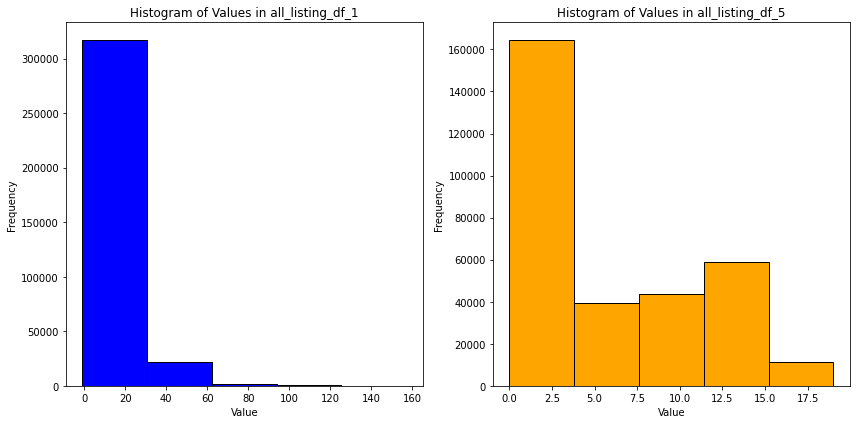

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

temp_df_1 = all_listing_df_1.copy()
temp_df_5 = all_listing_df_5.copy()

# Factorize 'property_type' for temporary DataFrames
temp_df_1['property_type'] = pd.factorize(temp_df_1['property_type'])[0]
temp_df_5['property_type'] = pd.factorize(temp_df_5['property_type'])[0]

plt.figure(figsize=(12, 6))

# Plot the histogram of 'property_type' in all_listing_df_1
plt.subplot(1, 2, 1)
temp_df_1['property_type'].plot(kind='hist', bins=5, edgecolor='black', color='blue')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values in all_listing_df_1')

# Plot the histogram of 'property_type' in all_listing_df_5
plt.subplot(1, 2, 2)
temp_df_5['property_type'].plot(kind='hist', bins=5, edgecolor='black', color='orange')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values in all_listing_df_5')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


We can see that the distribution is heavily skewed in both the distribution and the histograms, so there are many categories that occur quite rarely. Thus, we can filter to keep the categories that capture 99.5% of the variation in property type

In [17]:
print(f"{len(all_listing_df_5['property_type'].unique())} out of {len(all_listing_df_4['property_type'].unique())} property types are greater than {threshold}")

rows_removed = len(all_listing_df_4) - len(all_listing_df_5)
print(f"Number of rows removed: {rows_removed}")
print(f"the property types remaining are: \n {all_listing_df_5['property_type'].unique()}")


20 out of 150 property types are greater than 0.005
Number of rows removed: 20343
the property types remaining are: 
 ['Private room in rental unit' 'Private room in townhouse'
 'Entire rental unit' 'Entire guest suite'
 'Private room in bed and breakfast' 'Entire loft' 'Private room in home'
 'Entire guesthouse' 'Entire townhouse' 'Room in boutique hotel'
 'Entire condo' 'Private room in guest suite' 'Entire home'
 'Private room in condo' 'Entire villa' 'Entire serviced apartment'
 'Room in hotel' 'Entire cottage' 'Entire vacation home' 'Entire bungalow']


In [18]:
all_listing_df_5["room_type"].value_counts()

room_type
Entire home/apt    237997
Private room        80028
Name: count, dtype: int64

### Dealing with the property type

Since there are over 150 unique property types in the dataframe (but we think the type of listing will still be important for avaliability prediction), we want to try and reduce the number of categories for this variable

In [19]:
all_listing_df['property_type'].unique()

array(['Private room in rental unit', 'Private room in townhouse',
       'Private room in houseboat', 'Entire rental unit',
       'Entire guest suite', 'Private room in bed and breakfast',
       'Entire loft', 'Private room in home', 'Entire guesthouse',
       'Private room in boat', 'Entire townhouse',
       'Room in boutique hotel', 'Entire condo', 'Private room in loft',
       'Private room in guest suite', 'Entire home', 'Boat',
       'Private room in farm stay', 'Houseboat',
       'Room in bed and breakfast', 'Private room in condo',
       'Entire chalet', 'Private room in guesthouse',
       'Shared room in rental unit', 'Shared room in home',
       'Private room in island', 'Entire villa', 'Private room in villa',
       'Private room in tiny home', 'Private room in casa particular',
       'Entire serviced apartment', 'Barn', 'Private room in bungalow',
       'Entire cabin', 'Room in hotel', 'Entire place',
       'Private room in serviced apartment', 'Room in aparth

In [20]:
all_listing_df_5

,id,listing_url,host_name,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_picture_url,...,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,location
0,2.818000e+03,https://www.airbnb.com/rooms/2818,Daniel,2008-09-24,"Amsterdam, Netherlands",within an hour,100%,100%,t,https://a0.muscache.com/im/users/3159/profile_...,...,4.98,4.69,4.82,t,1.0,0.0,1.0,0.0,1.86,Amsterdam
1,2.016800e+04,https://www.airbnb.com/rooms/20168,Alexander,2009-12-02,"Amsterdam, Netherlands",within an hour,100%,98%,f,https://a0.muscache.com/im/pictures/user/65092...,...,4.62,4.87,4.49,t,2.0,0.0,2.0,0.0,2.22,Amsterdam
3,2.887100e+04,https://www.airbnb.com/rooms/28871,Edwin,2010-05-13,"Amsterdam, Netherlands",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/9986b...,...,4.94,4.96,4.83,f,2.0,0.0,2.0,0.0,2.92,Amsterdam
4,2.905100e+04,https://www.airbnb.com/rooms/29051,Edwin,2010-05-13,"Amsterdam, Netherlands",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/9986b...,...,4.92,4.87,4.77,f,2.0,0.0,2.0,0.0,4.16,Amsterdam
5,4.439100e+04,https://www.airbnb.com/rooms/44391,Jan,2010-08-08,"Amsterdam, Netherlands",within an hour,100%,100%,f,https://a0.muscache.com/im/users/194779/profil...,...,4.90,4.68,4.50,f,1.0,1.0,0.0,0.0,0.30,Amsterdam
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342231,5.295024e+07,https://www.airbnb.com/rooms/52950237,Edit,2021-10-23,NaN,within an hour,100%,94%,f,https://a0.muscache.com/im/pictures/user/37293...,...,5.00,4.80,4.80,t,1.0,1.0,0.0,0.0,0.46,Zurich
342232,5.721959e+17,https://www.airbnb.com/rooms/572195881887326595,Sinha‘S Swiss,2017-09-22,Switzerland,within an hour,100%,93%,f,https://a0.muscache.com/im/pictures/user/b5578...,...,4.90,4.80,4.70,t,18.0,18.0,0.0,0.0,1.69,Zurich
342233,4.607863e+07,https://www.airbnb.com/rooms/46078634,Lukas,2020-10-27,"Rümlang, Switzerland",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/58d7b...,...,4.95,4.68,4.89,t,10.0,0.0,10.0,0.0,0.83,Zurich
342234,4.647998e+07,https://www.airbnb.com/rooms/46479980,Lukas,2020-10-27,"Rümlang, Switzerland",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/58d7b...,...,4.92,4.92,4.85,t,10.0,0.0,10.0,0.0,0.65,Zurich


In [21]:
####################### DO ALL OF THE DATA VERIFICATION STUFF HERE ###############################

'''

Target:  For our machine learning project, we want to try and predict a Airbnb's avaliability for a given month using listing data.


Part 1: 

TO DO FOR DATA CHECKING + VERIFICATION:
- remove columns that have significant amount of NAN calues
- check that there is no property with number of available days > number of days in each  month 
- Check avalibalities (outcome variable) and make sure it is evenly distributed/ resample if needed 


TO DO FOR CONSISTENCY ANALYSIS:
- change dataframe to calculate avalaibilty per month and per location 
- plot average days avaliable for each city
- decide how to allocate consistent vs inconsistent cittes


Part 2:

RUN MODELS: 

Built and Run and test 2 models to try and predict monthly avaliabiltiy 

Model options: NN, linear regression 


'''



#the stuff below is to get the data needed to train the model once the dfs have been cleaned up

"\n\nTarget:  For our machine learning project, we want to try and predict a Airbnb's avaliability for a given month using listing data.\n\n\nPart 1: \n\nTO DO FOR DATA CHECKING + VERIFICATION:\n- remove columns that have significant amount of NAN calues\n- check that there is no property with number of available days > number of days in each  month \n- Check avalibalities (outcome variable) and make sure it is evenly distributed/ resample if needed \n\n\nTO DO FOR CONSISTENCY ANALYSIS:\n- change dataframe to calculate avalaibilty per month and per location \n- plot average days avaliable for each city\n- decide how to allocate consistent vs inconsistent cittes\n\n\nPart 2:\n\nRUN MODELS: \n\nBuilt and Run and test 2 models to try and predict monthly avaliabiltiy \n\nModel options: NN, linear regression \n\n\n"

## Consistency Analysis

### Creating dataset for average avaliability of listings per month per city

In [22]:

## add code that checks for the id 

def load_rental_data(city_name):
    """
    Load rental data for a specific city from a subdirectory.
    
    Parameters:
    - city_name (str): The name of the city.

    Returns:
    - pd.DataFrame: The loaded DataFrame.
    """
    # Construct the directory path based on the city name
    directory_path = f"home_rentals/{city_name}"
    
    # Assuming the file is named 'calendar.csv.gz'
    file_path = f"{directory_path}/calendar.csv.gz"
    
    try:
        # Load the DataFrame from the specified file
        df = pd.read_csv(file_path, compression='gzip')
        
        # You can perform additional processing on the DataFrame if needed
        
        # Return the loaded DataFrame
        return df
    except FileNotFoundError:
        # Handle the case where the file is not found
        print(f"Data not found for {city_name}. Check the directory path and file name.")
        return None
    

def filter_ids(df1, df2):
    """
    Filter out ID values in df1 that are not available in df2.

    Parameters:
    - df1 (pd.DataFrame): The first DataFrame.
    - df2 (pd.DataFrame): The second DataFrame.
    - id_column (str): The column containing the ID values.

    Returns:
    - pd.DataFrame: The filtered DataFrame.
    """
    id_column = "id"
    filtered_df = df1[df1["listing_id"].isin(df2["id"])]
    return filtered_df



def averageavaliability(city, latest_df):

    cityname = city
    citydata = load_rental_data(cityname) 

    #filter our ID's that are NOT present in our cleaned all_listings 

    filtered_citydata = filter_ids(citydata, latest_df)
    
    filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
    filtered_citydata["month"] = filtered_citydata["date"].dt.month
    filtered_citydata["year"] = filtered_citydata["date"].dt.year
    filtered_citydata['month_year'] = filtered_citydata['month'].astype(str) + '-' + filtered_citydata['year'].astype(str)

    # make a new data frame
    ave_month = (filtered_citydata[filtered_citydata['available'] == 't'].groupby(['listing_id', 'month_year']).size().unstack(fill_value=0).stack().reset_index(name='days_available'))
    
    # Calculate the average days_available for each month_year (making sure that it rounds to full numbers)
    ave_month = (ave_month.groupby('month_year')['days_available'].mean().round(0).reset_index(name='average_days_available'))
    # convert the month_year column to datetime format 
    ave_month['month_year'] = pd.to_datetime(ave_month['month_year'], format='%m-%Y').dt.to_period('M')

    # sort the rows by ascending dates
    ave_month = ave_month.sort_values('month_year')

    # reset the row index
    ave_month.reset_index(drop=True, inplace=True)

    ave_month['location'] = city

    return ave_month




In [23]:
# Will take 10 mins to run but it WORKSSSSSS SLAY

all_locations = all_listing_df_5["location"].unique()

average_by_month = pd.DataFrame()

for location in all_locations:
    ave_month = averageavaliability(location, all_listing_df_5)
    average_by_month = pd.concat([average_by_month, ave_month], axis=0)
    print(location)


    # NOTE: For Madrid, the line "filtered_citydata = filter_ids(citydata, all_listing_df_5)" returns an empty df --> all listings have been 
    # removed from all_listing_df_5!!! Something has gone wrong, because all_listing_df_5 does have data for Madrid. something is wrong when 
    # the function uses it, idk why

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Amsterdam


C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Barcelona


C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Euskadi


C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Geneva


C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Ireland


C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Lisbon


C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Los Angeles
Madrid


C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Malaga


C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Mallorca


C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Malta


C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Menorca


C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Mexico City


C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Milan


C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Naples


C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Rome


C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Rotterdam


C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

San Diego


C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

San Francisco


C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Tokyo


C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Toronto


C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Valencia


C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Vancouver


C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Vienna


C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Washington


C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Winnipeg


C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Zurich


C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3489930091.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata['month_year'] = filtered_citydata['month'].astype(str) + '-' + filtered_citydata['year'].astype(str)


In [24]:
# note that all of the properties in Madrid have no listing ID in the listings data file. Thus, we cannot merge the calendar and the listings
# data for the city because we do not have the corresponding IDs. As such, the function removed all of the Madrid properties. 

average_by_month["location"].unique()

array(['Amsterdam', 'Barcelona', 'Euskadi', 'Geneva', 'Ireland', 'Lisbon',
       'Los Angeles', 'Malaga', 'Mallorca', 'Malta', 'Menorca',
       'Mexico City', 'Milan', 'Naples', 'Rome', 'Rotterdam', 'San Diego',
       'San Francisco', 'Tokyo', 'Toronto', 'Valencia', 'Vancouver',
       'Vienna', 'Washington', 'Winnipeg', 'Zurich'], dtype=object)

### Correcting for additional months

In [25]:
# check for the unique "month_year" vaues in the average_by_month dataframe. This allows us to see what months are covered by the data
average_by_month["month_year"].unique()

<PeriodArray>
['2022-09', '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
 '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09', '2023-10']
Length: 14, dtype: period[M]

In [26]:
# All of the locations should have data from 2022-09 until 2023-09
# loop through the dataframe and remove any month(s) for any locations that have observations over more than these 12 months

# Create a boolean mask based on the specified conditions
mask = average_by_month['month_year'] == "2023-10"

# Use the boolean mask to filter the DataFrame and keep only the rows that don't match the conditions
average_by_month = average_by_month[~mask]

# check that we got the result we wanted
average_by_month["month_year"].value_counts()



month_year
2022-09    26
2022-10    26
2022-11    26
2022-12    26
2023-01    26
2023-02    26
2023-03    26
2023-04    26
2023-05    26
2023-06    26
2023-07    26
2023-08    26
2023-09    26
Freq: M, Name: count, dtype: int64

As can be seen above, all of the locations have data ranging from 2022-09 to 2023-09, except for Euskadi which has an extra month of data (2023-10). This is an additional month in comparison to the other locations, as such we will remove it to have a consistent range of data between all of the locations.


Next, we will look at the seasonality of each month for each location, comparing it between the locations and calculating a seasonality index. We do this so as to have an idea of how consistent the bookings are per month for each location.

In [27]:
# Calculate the seasonality index for each month of each location

# find the average availability per month between all locations
seasonality_df = average_by_month
seasonality_df['Average'] = seasonality_df.groupby('month_year')['average_days_available'].transform('mean')

# calculate the seasonality index for each location's month and append it to the dataframe 
seasonality_df['Seasonality_Index_%'] = round((seasonality_df['average_days_available'] / seasonality_df['Average']) * 100,1)

# remove the Average column since it is no longer needed
seasonality_df = seasonality_df.drop("Average", axis=1)

# show the data frame 
seasonality_df




,month_year,average_days_available,location,Seasonality_Index_%
0,2022-09,4.0,Amsterdam,101.0
1,2022-10,7.0,Amsterdam,47.0
2,2022-11,11.0,Amsterdam,58.6
3,2022-12,11.0,Amsterdam,57.3
4,2023-01,14.0,Amsterdam,72.4
...,...,...,...,...
8,2023-05,16.0,Zurich,94.3
9,2023-06,16.0,Zurich,101.0
10,2023-07,16.0,Zurich,100.5
11,2023-08,16.0,Zurich,100.5


The seasonality index indicates how the availability per month of each location varies with respect to a seasonal pattern. A seasonality index value above 100% indicates a period of higher demand or availability compared to the average. A seasonality index value below 100%, instead, indicates a period of lower demand or availability compared to the average. Finally, a seasonality index of 100% suggests that the availability is in line with the average, without any significant seasonal deviation.

### PICK IF YOU WANT LINE OR BAR CHARTS FOR THE SEASONALITY!!!!

<Figure size 864x432 with 0 Axes>

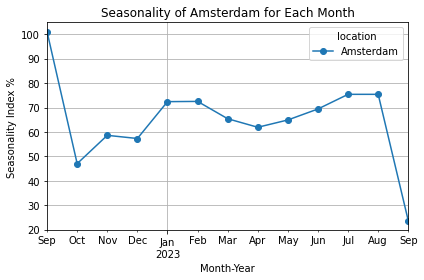

<Figure size 864x432 with 0 Axes>

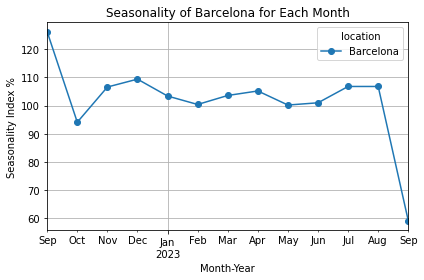

<Figure size 864x432 with 0 Axes>

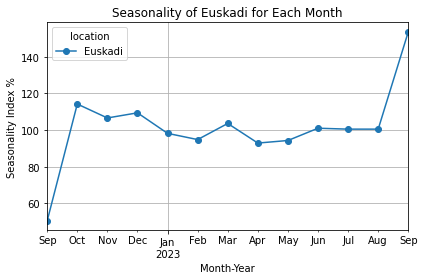

<Figure size 864x432 with 0 Axes>

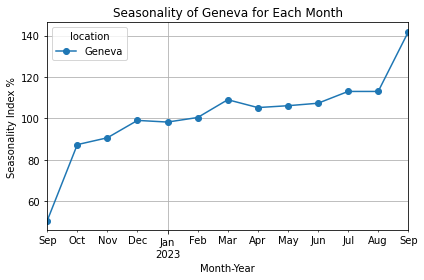

<Figure size 864x432 with 0 Axes>

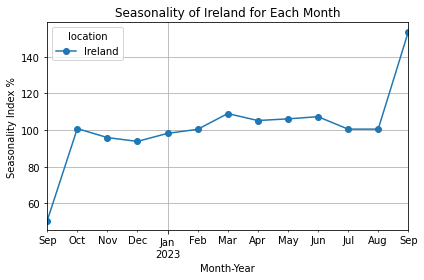

<Figure size 864x432 with 0 Axes>

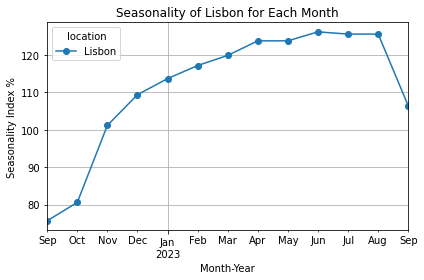

<Figure size 864x432 with 0 Axes>

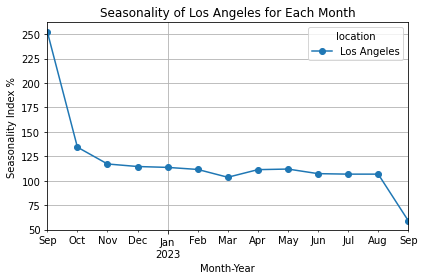

<Figure size 864x432 with 0 Axes>

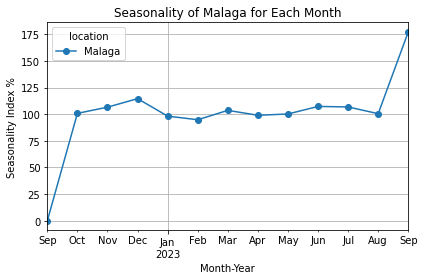

<Figure size 864x432 with 0 Axes>

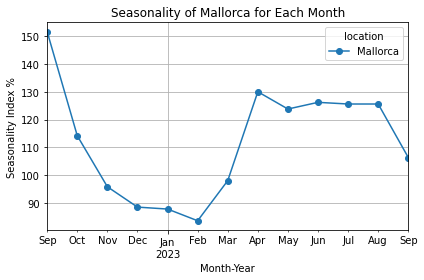

<Figure size 864x432 with 0 Axes>

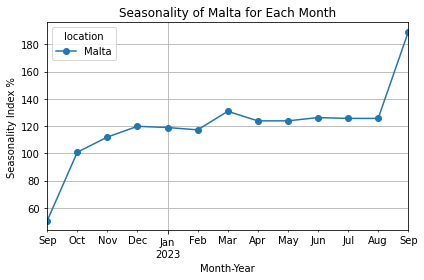

<Figure size 864x432 with 0 Axes>

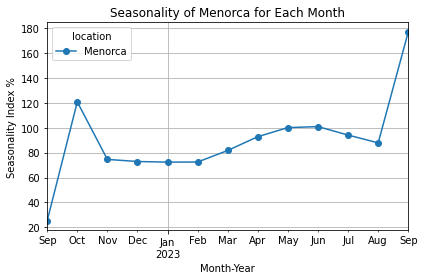

<Figure size 864x432 with 0 Axes>

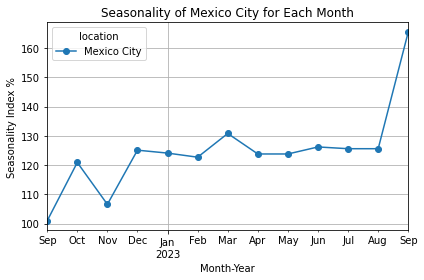

<Figure size 864x432 with 0 Axes>

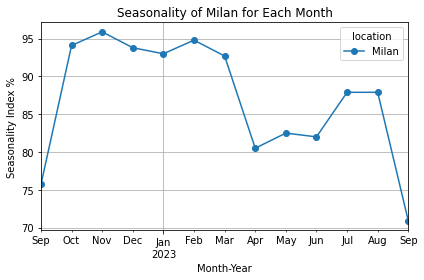

<Figure size 864x432 with 0 Axes>

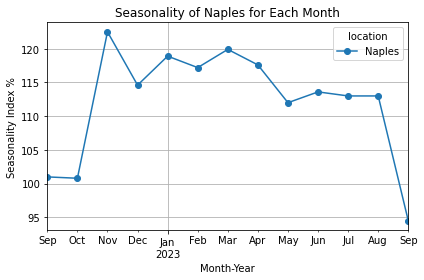

<Figure size 864x432 with 0 Axes>

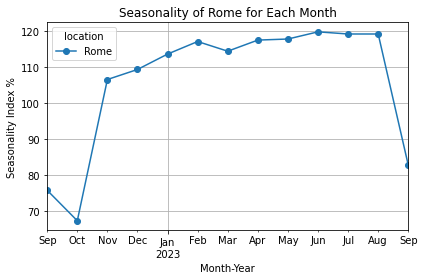

<Figure size 864x432 with 0 Axes>

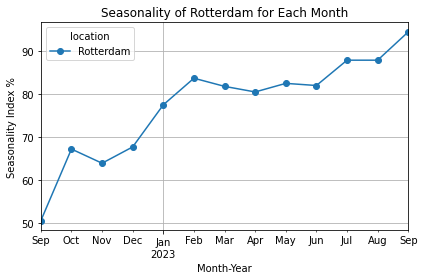

<Figure size 864x432 with 0 Axes>

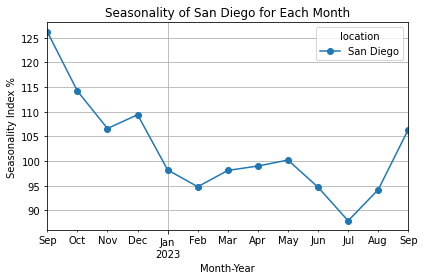

<Figure size 864x432 with 0 Axes>

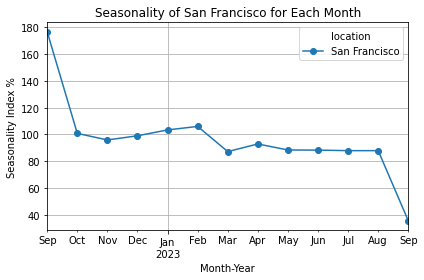

<Figure size 864x432 with 0 Axes>

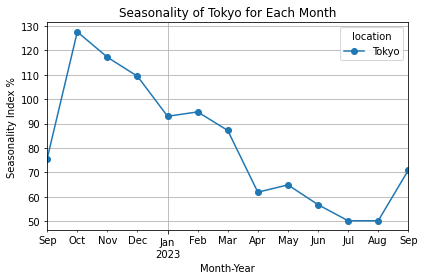

<Figure size 864x432 with 0 Axes>

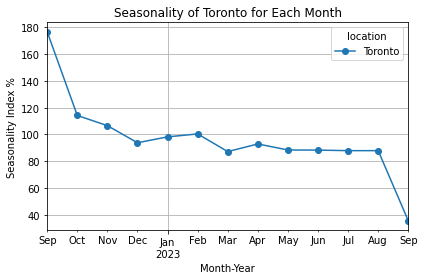

<Figure size 864x432 with 0 Axes>

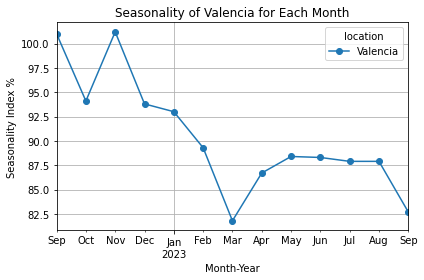

<Figure size 864x432 with 0 Axes>

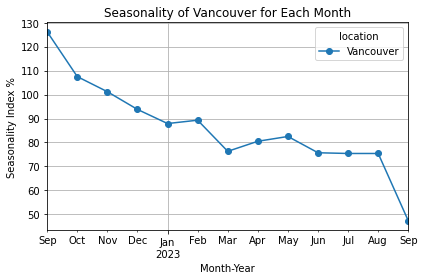

<Figure size 864x432 with 0 Axes>

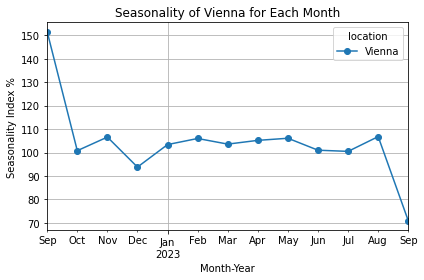

<Figure size 864x432 with 0 Axes>

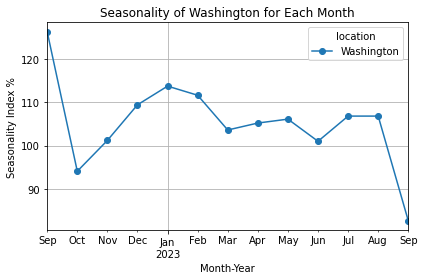

<Figure size 864x432 with 0 Axes>

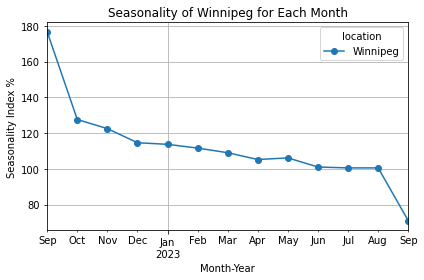

<Figure size 864x432 with 0 Axes>

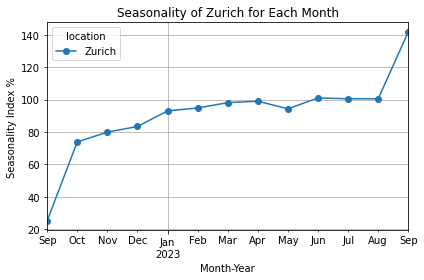

In [38]:
import matplotlib.pyplot as plt

# Plot the monthly seasonality for each location

seasonality_locations = seasonality_df["location"].unique()


for location in seasonality_locations:
    season_given_location = seasonality_df[seasonality_df["location"] == location]

    # Pivot the DataFrame for better plotting
    pivot_df = season_given_location.pivot(index='month_year', columns='location', values='Seasonality_Index_%')

    plt.figure(figsize=(12, 6))
    pivot_df.plot(marker='o', linestyle='-')
    plt.title(f'Seasonality of {location} for Each Month')
    plt.xlabel('Month-Year')
    plt.ylabel('Seasonality Index %')
    plt.grid(True)
    plt.tight_layout()
    plt.show()



C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\198467399.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)


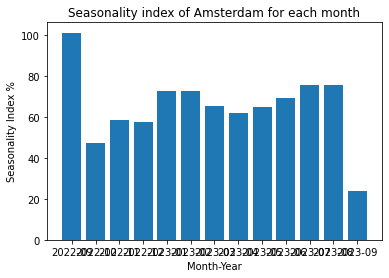

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\198467399.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)


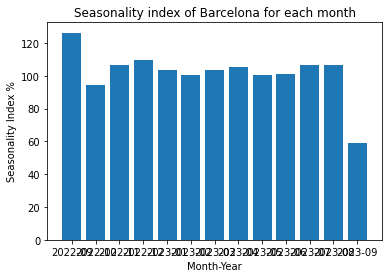

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\198467399.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)


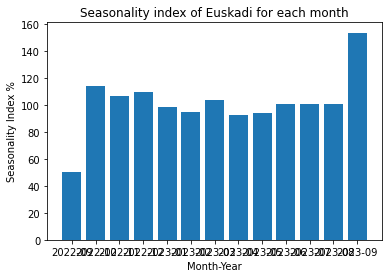

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\198467399.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)


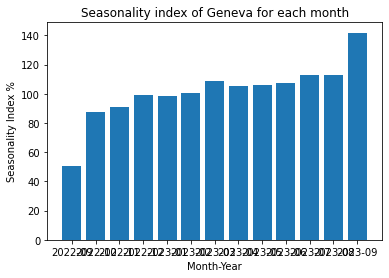

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\198467399.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)


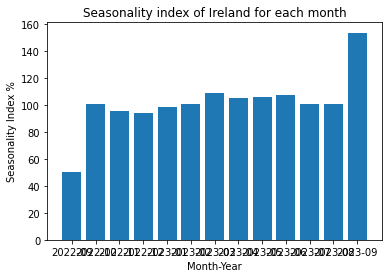

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\198467399.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)


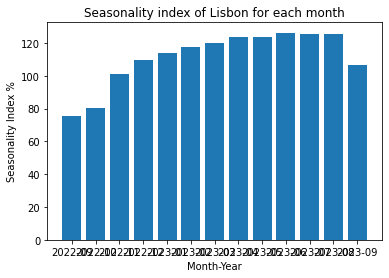

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\198467399.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)


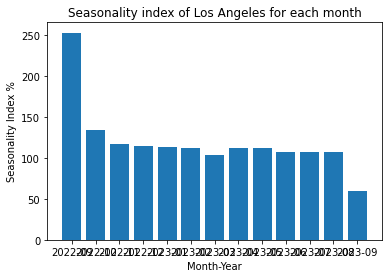

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\198467399.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)


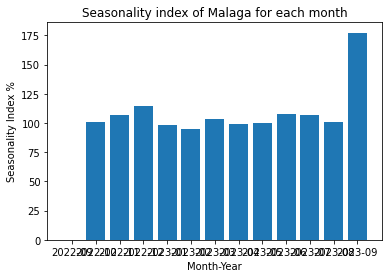

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\198467399.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)


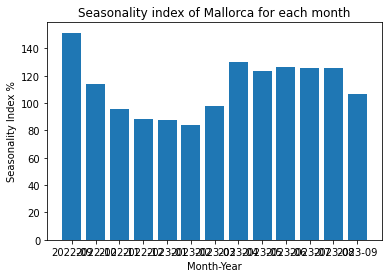

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\198467399.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)


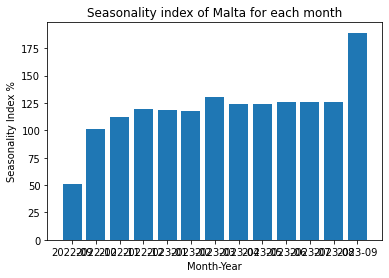

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\198467399.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)


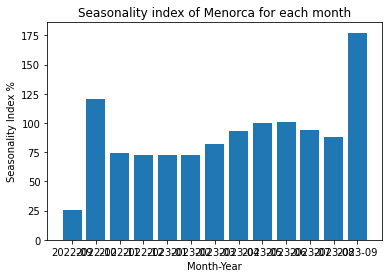

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\198467399.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)


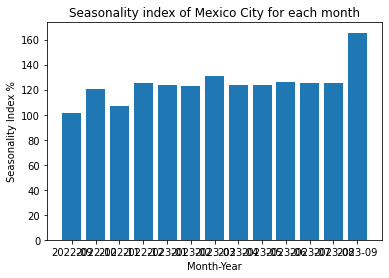

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\198467399.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)


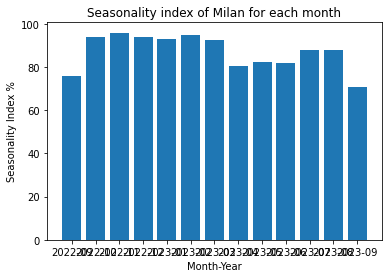

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\198467399.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)


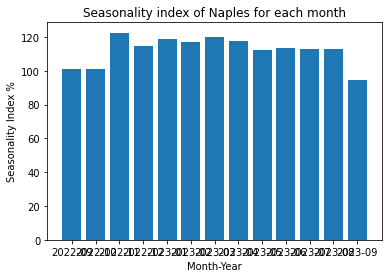

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\198467399.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)


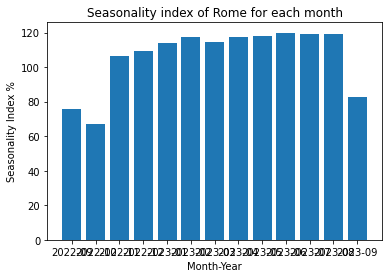

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\198467399.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)


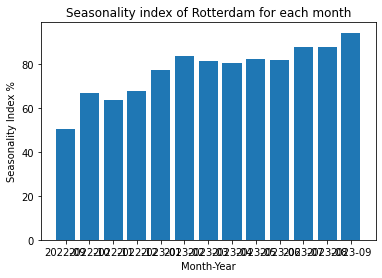

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\198467399.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)


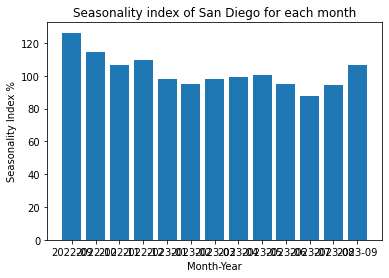

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\198467399.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)


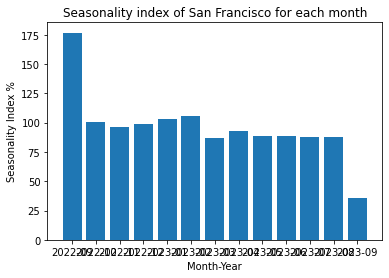

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\198467399.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)


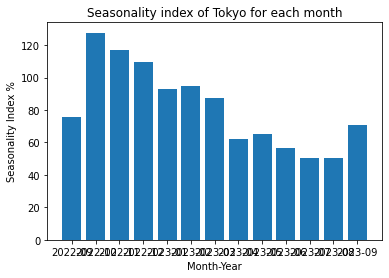

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\198467399.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)


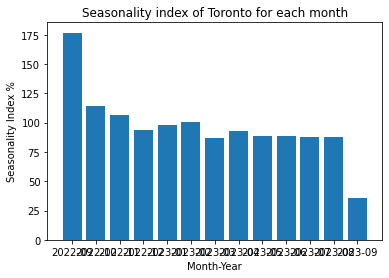

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\198467399.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)


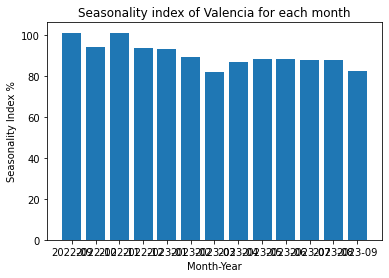

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\198467399.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)


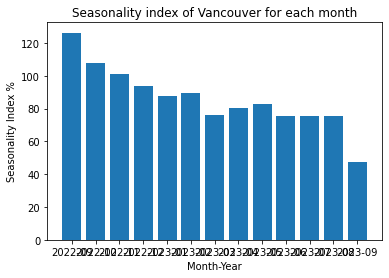

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\198467399.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)


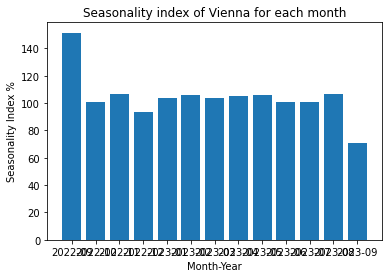

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\198467399.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)


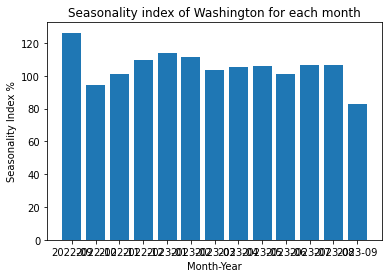

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\198467399.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)


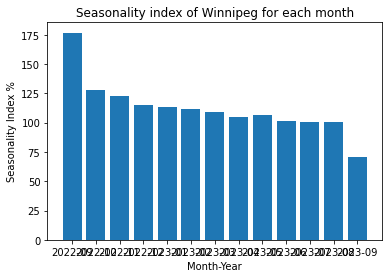

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\198467399.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)


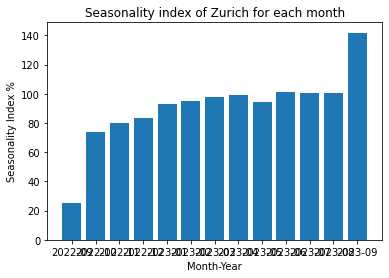

In [39]:
import matplotlib.pyplot as plt

# Plot the monthly seasonality for each location

seasonality_locations = seasonality_df["location"].unique()

'''
### TYPE 1 OF BAR CHART: ###

for location in seasonality_locations:
    season_given_location = seasonality_df[seasonality_df["location"] == location]

    # Pivot the DataFrame for better plotting
    pivot_df = season_given_location.pivot(index='month_year', columns='location', values='Seasonality_Index_%')

    # Plotting a bar chart for each location
    plt.figure(figsize=(8, 4))
    
    bar_width = 0.95  # Adjust the width of the bars as needed
    bar_positions = range(len(pivot_df.index))

    for i, loc in enumerate(pivot_df.columns):
        plt.bar([pos + i * bar_width for pos in bar_positions], pivot_df[loc], width=bar_width, label=loc)

    plt.title(f'Seasonality of {location} for Each Month')
    plt.xlabel('Month')
    plt.ylabel('Seasonality Index %')
    plt.xticks([pos + (len(pivot_df.columns) - 1) * bar_width / 2 for pos in bar_positions], pivot_df.index)
    plt.legend()
    #plt.grid(True)
    plt.tight_layout()
    plt.show()

'''

### TYPE 2 FOR BAR CHART: ###

for location in seasonality_locations:

    season_given_location = seasonality_df[seasonality_df["location"] == location]

    av = season_given_location['Seasonality_Index_%']

    season_given_location['month_year'] = season_given_location['month_year'].astype(str)

    import matplotlib.pyplot as plt

    plt.bar(season_given_location['month_year'], av )
    plt.xlabel('Month-Year')
    plt.ylabel('Seasonality Index %')
    plt.title(f'Seasonality index of {location} for each month')
    plt.show()



### !!!!!!!!!! NOTE: MALAGA HAS ZERO AVAILABILITY IN SEPTEMBER, SO ALSO THE SEASONALITY INDEX IS = 0. SHOULD MAYBE LOOK INTO THIS???

Also, do we want to plot the availability per month per location? Or only seasonality index plots. Just in case I made plots for availability per month too

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3042789529.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


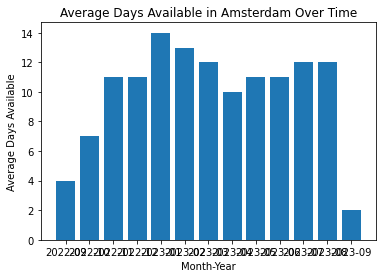

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3042789529.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


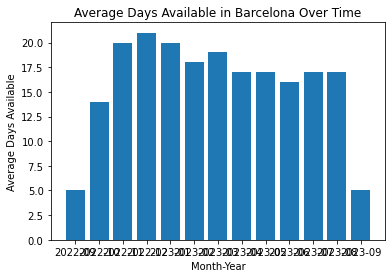

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3042789529.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


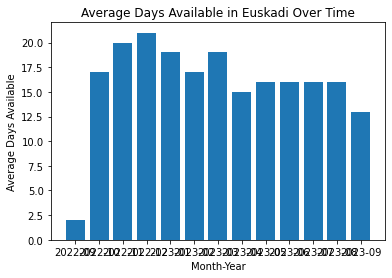

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3042789529.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


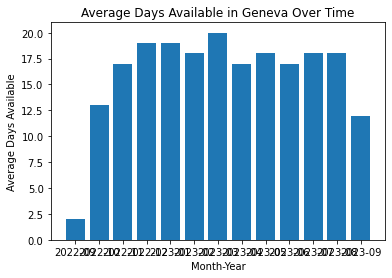

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3042789529.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


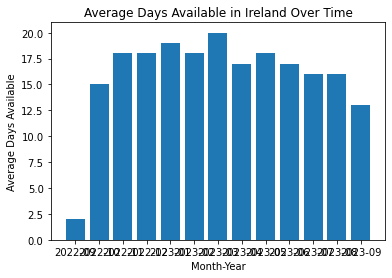

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3042789529.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


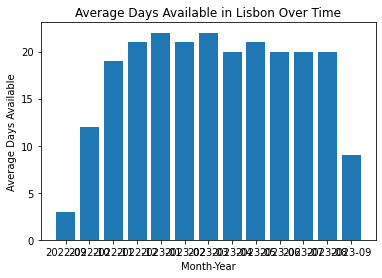

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3042789529.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


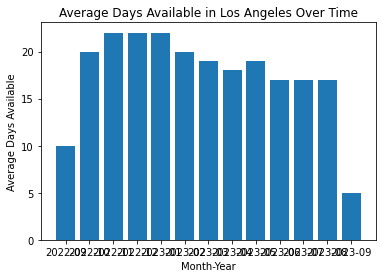

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3042789529.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


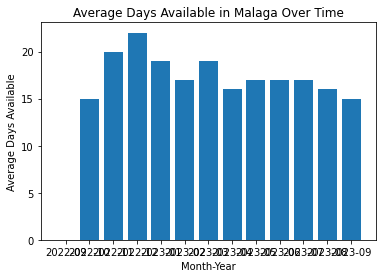

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3042789529.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


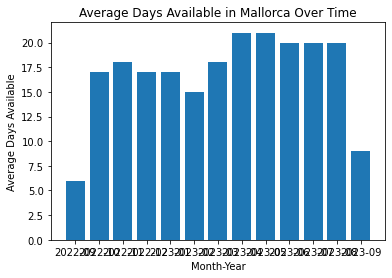

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3042789529.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


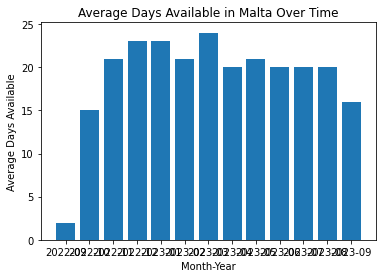

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3042789529.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


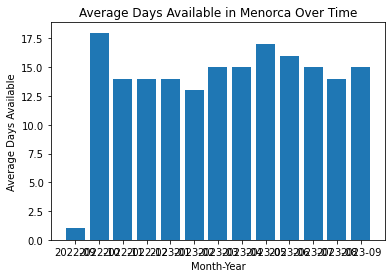

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3042789529.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


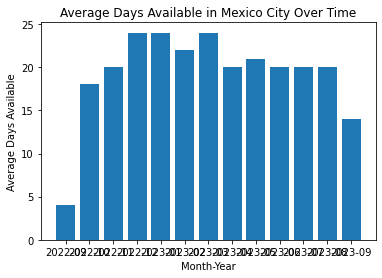

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3042789529.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


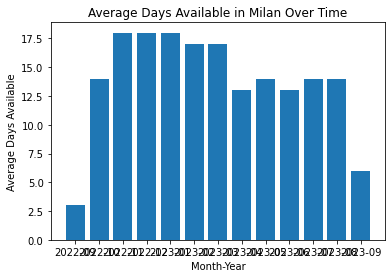

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3042789529.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


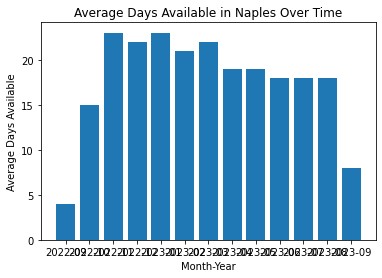

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3042789529.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


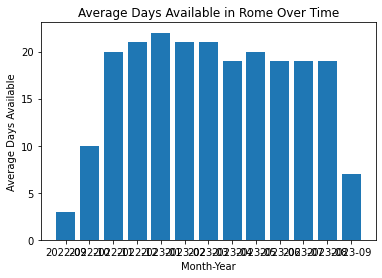

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3042789529.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


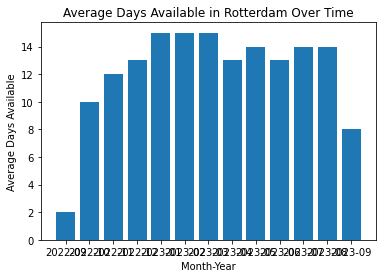

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3042789529.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


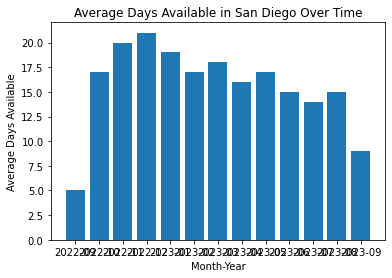

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3042789529.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


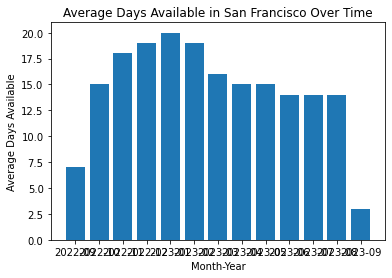

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3042789529.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


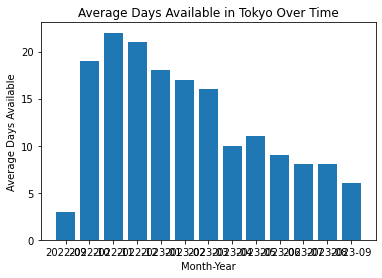

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3042789529.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


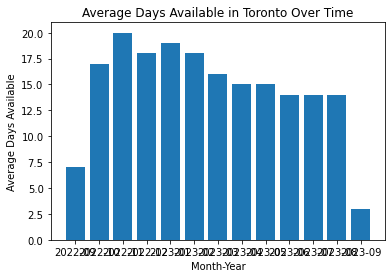

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3042789529.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


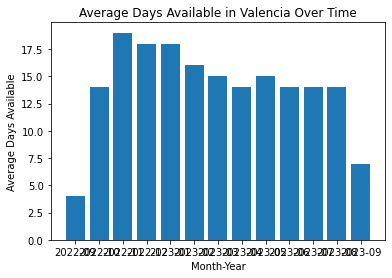

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3042789529.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


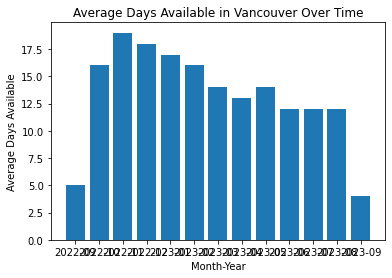

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3042789529.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


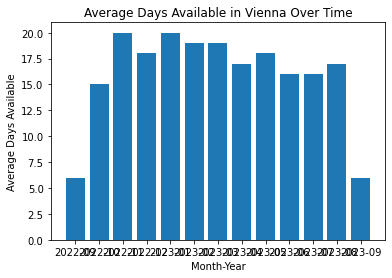

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3042789529.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


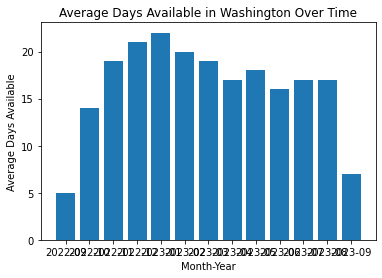

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3042789529.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


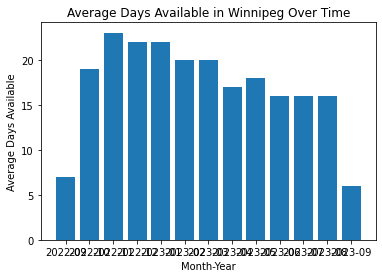

C:\Users\elisa\AppData\Local\Temp\ipykernel_25788\3042789529.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


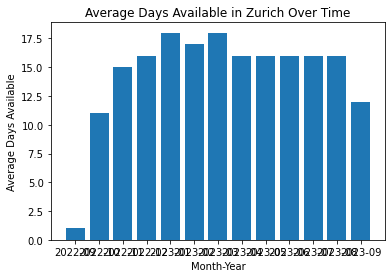

In [40]:
# make plots for each month with the average availbility for each month

all_the_locations = average_by_month["location"].unique()

for location in all_the_locations:
    location_name = average_by_month[average_by_month['location']==location]

    av = location_name['average_days_available']

    location_name['month_year'] = location_name['month_year'].astype(str)


    import matplotlib.pyplot as plt

    plt.bar(location_name['month_year'], av )
    plt.xlabel('Month-Year')
    plt.ylabel('Average Days Available')
    plt.title(f'Average Days Available in {location} Over Time')
    plt.show()


In [30]:
''' 
TO DO FOR MODEL GENERATION:
- split the data set into test and train  
- etc. 
'''


' \nTO DO FOR MODEL GENERATION:\n- split the data set into test and train  \n- etc. \n'

## Pricing Analysis


In [1]:
#PLEASE CHECK IF THIS WORKS AND MAKES SENSE (i don't have enough ram in my laptop to concatenate the original dataframes ☠)



# Plot distribution of prices
plt.figure(figsize=(12, 6))
sns.histplot(all_listing_df_4['price'], bins=30, kde=True)
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Plot distribution of prices by country
plt.figure(figsize=(14, 6))
sns.boxplot(x='region_name', y='price', data=all_listing_df_4)
plt.title('Distribution of Prices by Country')
plt.xlabel('Country')
plt.ylabel('Price')
plt.xticks(rotation=45, ha='right')
plt.show()

# Calculate price per bedroom and price per bed
all_listing_df_4['price_per_bedroom'] = all_listing_df_4['price'] / all_listing_df_4['bedrooms']
all_listing_df_4['price_per_bed'] = all_listing_df_4['price'] / all_listing_df_4['beds']

# Plot distribution of price per bedroom and price per bed
plt.figure(figsize=(12, 6))
sns.histplot(all_listing_df_4['price_per_bedroom'], bins=30, kde=True, label='Price per Bedroom')
sns.histplot(all_listing_df_4['price_per_bed'], bins=30, kde=True, label='Price per Bed')
plt.title('Distribution of Price per Bedroom and Price per Bed')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot distribution of price per bedroom and price per bed by country
plt.figure(figsize=(14, 6))
sns.boxplot(x='region_name', y='price_per_bedroom', data=all_listing_df_4, label='Price per Bedroom')
sns.boxplot(x='region_name', y='price_per_bed', data=all_listing_df_4, label='Price per Bed')
plt.title('Distribution of Price per Bedroom and Price per Bed by Country')
plt.xlabel('Country')
plt.ylabel('Price')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()


NameError: name 'all_listing_df' is not defined